# Spline Regression

Let's check spline regression! For that I will include a custom model to our pipeline sklearn object. You can reuse tthis object as you please, it will run spline regression!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import scipy.interpolate as si
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, RANSACRegressor,\
                                 TheilSenRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error

In [2]:
def get_bspline_basis(knots, degree=3, periodic=False):
    """Get spline coefficients for each basis spline."""
    nknots = len(knots)
    y_dummy = np.zeros(nknots)

    knots, coeffs, degree = si.splrep(knots, y_dummy, k=degree,
                                      per=periodic)
    ncoeffs = len(coeffs)
    bsplines = []
    for ispline in range(nknots):
        coeffs = [1.0 if ispl == ispline else 0.0 for ispl in range(ncoeffs)]
        bsplines.append((knots, coeffs, degree))
    return bsplines

The only thing needed to implement a model is to implement the fit and transform methods!

In [3]:
class BSplineFeatures(TransformerMixin):
    def __init__(self, knots, degree=3, periodic=False):
        self.bsplines = get_bspline_basis(knots, degree, periodic=periodic)
        self.nsplines = len(self.bsplines)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        nsamples, nfeatures = X.shape
        features = np.zeros((nsamples, nfeatures * self.nsplines))
        for ispline, spline in enumerate(self.bsplines):
            istart = ispline * nfeatures
            iend = (ispline + 1) * nfeatures
            features[:, istart:iend] = si.splev(X, spline)
        return features

In [4]:
nyc_pumpkins = pd.read_csv("./new-york_9-24-2016_9-30-2017.csv")
cat_map = {
    'sml': 0,
    'med': 1,
    'med-lge': 2,
    'lge': 3,
    'xlge': 4,
    'exjbo': 5
}
nyc_pumpkins = nyc_pumpkins.assign(
    size=nyc_pumpkins['Item Size'].map(cat_map),
    price=nyc_pumpkins['High Price'] + nyc_pumpkins['Low Price'] / 2,
    size_class=(nyc_pumpkins['Item Size'].map(cat_map) >= 2).astype(int)
)
nyc_pumpkins = nyc_pumpkins.drop([c for c in nyc_pumpkins.columns if c not in ['size', 'price', 'size_class']], 
                                 axis='columns')
nyc_pumpkins = nyc_pumpkins.dropna()

In [5]:
nyc_pumpkins.head(10)

,size,price,size_class
0,4.0,245.0,1
1,3.0,245.0,1
2,4.0,215.0,1
3,3.0,215.0,1
4,2.0,200.0,1
5,4.0,245.0,1
6,3.0,230.0,1
7,1.0,280.0,0
8,4.0,245.0,1
9,3.0,245.0,1


In [6]:
nyc_pumpkins.shape

(104, 3)

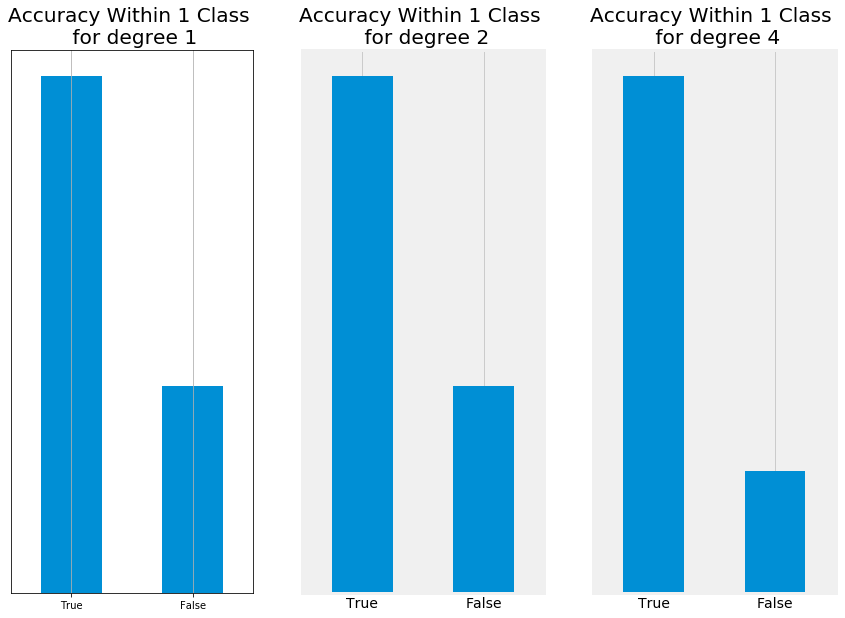

In [7]:
X_train, X_test, y_train, y_test = train_test_split(nyc_pumpkins['price'], nyc_pumpkins['size'], test_size=0.20, random_state=42, shuffle=True) #split 20% into test set

X_train[20]= -10
y_train[20] = 30

degrees = [1, 2, 4]
fig = plt.figure(figsize=(20,10))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees)+1, i + 2)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=True)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X_train[:, np.newaxis], y_train)

    # Evaluate the models using crossvalidation
    predicted_sizes = np.round(pipeline.predict(X_test[:, np.newaxis]))
    import matplotlib.pyplot as plt
    plt.style.use('fivethirtyeight')

    pd.Series(
        np.abs((np.array(y_test) - predicted_sizes).flatten()) <= 1
    ).value_counts().plot.bar(title='Accuracy Within 1 Class \n for degree {}'.format(degrees[i]))

As we know, with one outlier polynomial regression does pretty bad!

In [8]:
X_train, X_test, y_train, y_test = train_test_split(nyc_pumpkins['price'], nyc_pumpkins['size'], test_size=0.20, random_state=42, shuffle=True) #split 20% into test set

X_train[20]= -10
y_train[20] = 30

X_train = np.array(X_train).reshape(-1,1)
X_test = np.array(X_test).reshape(-1,1)

y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)



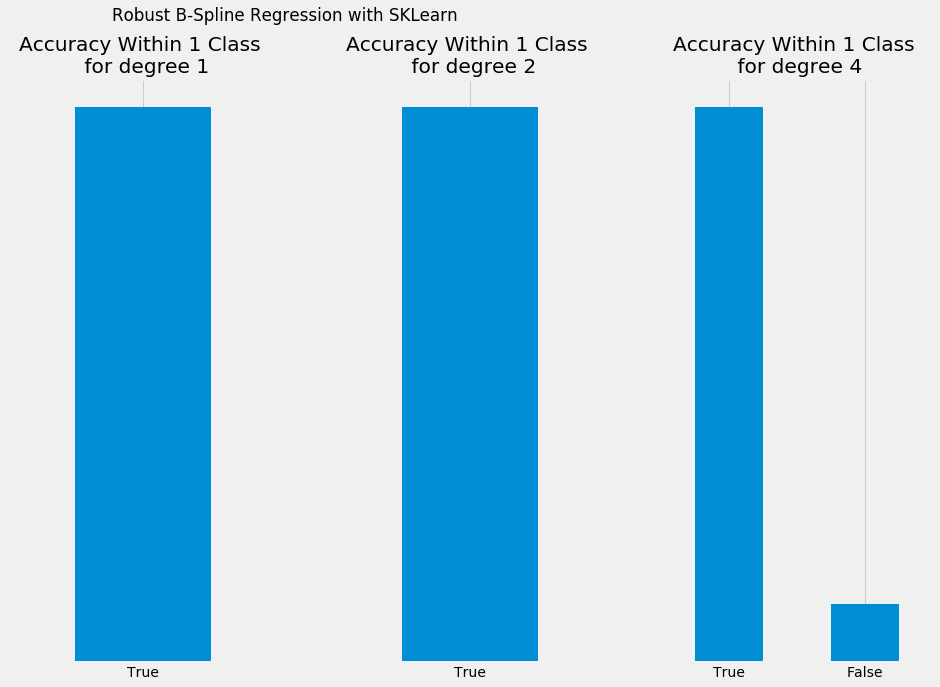

In [9]:

knots = np.linspace(0, 500, 20)


degrees = [1, 2, 4]
fig = plt.figure(figsize=(20,10))
fig.suptitle('Robust B-Spline Regression with SKLearn')
for i in range(len(degrees)):
    bspline_features = BSplineFeatures(knots, degree=degrees[i], periodic=False)
    model = make_pipeline(bspline_features, LinearRegression(fit_intercept=False))
    model.fit(X_train, y_train)    
    ax = plt.subplot(1, len(degrees)+1, i + 2)
    plt.setp(ax, xticks=(), yticks=())

    # Evaluate the models using crossvalidation
    predicted_sizes = np.round(model.predict(X_test))
    import matplotlib.pyplot as plt
    plt.style.use('fivethirtyeight')

    pd.Series(
        np.abs((np.array(y_test) - predicted_sizes).flatten()) <= 1
    ).value_counts().plot.bar(title='Accuracy Within 1 Class \n for degree {}'.format(degrees[i]))

But spline regression rocks! It is a robust regression! The issue in degree 4 we see is overfitting, another normal issue with polynomials in general! We tend to use spline regression up to degree 3.